In [3]:
import os
import torch
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [4]:
cd results/

/content/drive/My Drive/results


In [5]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data_utils
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F

In [6]:
'''
 Function make sure the dataset in training and test have perfectly balanced class.
 Returns train data, train labels, test data, test labels.
 Note training size needs to be divisible to the number of classes
'''
def balanceclass(train_portion, n_classes, x, y):     
  trainidx = np.array([None])
  testidx = np.array([None])
  for i in range(n_classes):  
    idx = np.where(y==i)[0]
    num = int(len(idx)*train_portion)  #ensure each class has required percentage of training & test samples
    np.random.shuffle(idx)     
    idxtrain = idx[:num]
    idxtest = idx[num:]
    trainidx = np.append(trainidx, idxtrain)
    testidx = np.append(testidx, idxtest)
  trainidx = trainidx[1:].astype(int)
  testidx = testidx[1:].astype(int)
  np.random.shuffle(trainidx)
  np.random.shuffle(testidx)
  trainx, trainy, testx, testy = x[trainidx], y[trainidx], x[testidx], y[testidx]
  return trainx, trainy, testx, testy

In [7]:
###### Function to introduce noisy labels
def flipy(trainy, portion):
  labels = np.arange(np.max(trainy+1))
  num = int(len(trainy) * portion)
  idx = np.random.choice(len(trainy), size = num, replace = False)
  new = np.random.choice(labels, size = num, replace = True) 
  trainy[idx] = new
  return trainy, idx


In [8]:
import os
# set seed for current GPU
seed = 20170922
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cudnn.deterministic = True

In [9]:
'''
functions to apply two-point, three-point, four-point mixup on current data and current loss
'''
def mixup2p(x, y, alpha):
    lam = np.random.beta(alpha, alpha)
    batch_size = len(x)
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1-lam) * x[index, :]
    y_a, y_b= y, y[index]  
    return mixed_x, y_a, y_b, lam

def mixup_criterion2p(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)   #mix up losses


def mixup3p(x, y, alpha):
    lam = np.random.dirichlet(alpha = np.ones(3)*alpha)
    batch_size = len(x)
    index = torch.randperm(batch_size).cuda()
    index2 = torch.randperm(batch_size).cuda()
    mixed_x = lam[0] * x + lam[1] * x[index, :] + lam[2] * x[index2, :]
    y_a, y_b, y_c= y, y[index], y[index2] 
    return mixed_x, y_a, y_b, y_c, lam

def mixup_criterion3p(criterion, pred, y_a, y_b, y_c, lam):
    return lam[0] * criterion(pred, y_a) + lam[1] * criterion(pred, y_b) + lam[2] * criterion(pred, y_c)


def mixup4p(x, y, alpha):
    lam = np.random.dirichlet(alpha = np.ones(4)*alpha)
    batch_size = len(x)
    index = torch.randperm(batch_size).cuda()
    index2 = torch.randperm(batch_size).cuda()
    index3 = torch.randperm(batch_size).cuda()
    mixed_x = lam[0] * x + lam[1] * x[index,:] + lam[2] * x[index2,:] + lam[3] * x[index3,:]
    y_a, y_b, y_c, y_d= y, y[index], y[index2], y[index3] 
    return mixed_x, y_a, y_b, y_c, y_d, lam

def mixup_criterion4p(criterion, pred, y_a, y_b, y_c, y_d, lam):
    return lam[0] * criterion(pred, y_a) + lam[1] * criterion(pred, y_b) + lam[2] * criterion(pred, y_c) + lam[3]*criterion(pred, y_d)

In [10]:
############################## training process ################################
def train2p(epoch):
    print(a2)
    print('\nEpoch: %d' % epoch)
    net2.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, lam = mixup2p(inputs, targets, a2)
        outputs2 = net2(inputs)
        loss2 = mixup_criterion2p(criterion, outputs2, targets_a.long(), targets_b.long(), lam)
        train_loss += loss2.item()
        _, predicted = torch.max(outputs2.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1-lam) * predicted.eq(targets_b.data).cpu().sum().float())
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 
                     'TrainAcc: {:.3f}'.format(100.*correct.item()/total))
    return 0

def train3p(epoch):
    print(a3)
    print('\nEpoch: %d' % epoch)
    net3.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, targets_c, lam = mixup3p(inputs, targets, a3)
        optimizer3.zero_grad()
        outputs3 = net3(inputs)
        loss3 = mixup_criterion3p(criterion, outputs3, targets_a.long(), targets_b.long(), targets_c.long(), lam)
        train_loss += loss3.item()
        _, predicted = torch.max(outputs3.data, 1)
        total += targets.size(0)
        correct += (lam[0] * predicted.eq(targets_a.data).cpu().sum().float()
                    + lam[1] * predicted.eq(targets_b.data).cpu().sum().float() + lam[2] * predicted.eq(targets_c.data).cpu().sum().float())
        loss3.backward()
        optimizer3.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 'TrainAcc: {:.3f}'.format(100.*correct.item()/total))    
    return 0


def train4p(epoch):
    print(a4)
    print('\nEpoch: %d' % epoch)
    net4.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets_a, targets_b, targets_c, targets_d, lam = mixup4p(inputs, targets, a4)
        optimizer4.zero_grad()
        outputs4 = net4(inputs)
        loss4 = mixup_criterion4p(criterion, outputs4, targets_a.long(), targets_b.long(), targets_c.long(), targets_d.long(), lam)
        train_loss += loss4.item()
        _, predicted = torch.max(outputs4.data, 1)
        total += targets.size(0)
        correct += (lam[0] * predicted.eq(targets_a.data).cpu().sum().float()
                    + lam[1] * predicted.eq(targets_b.data).cpu().sum().float() + lam[2] * predicted.eq(targets_c.data).cpu().sum().float() + lam[3]*predicted.eq(targets_d.data).cpu().sum().float())
        loss4.backward()
        optimizer4.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 'TrainAcc: {:.3f}'.format(100.*correct.item()/total))    
    return 0

def trainori(epoch):
    print('\nEpoch: %d' % epoch)
    criterion = nn.CrossEntropyLoss()
    netori.train()
    correct, total, train_loss = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizerori.zero_grad()
        outputsori = netori(inputs)
        lossori = criterion(outputsori, targets.long())      
        train_loss += lossori.item()
        _, predicted = torch.max(outputsori.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().float()
        lossori.backward()
        optimizerori.step()
    print('TrainLoss: {:.3f}'.format(train_loss/(batch_idx+1)), 'TrainAcc: {:.3f}'.format(100.*correct.item()/total))   
    return 0  


def test2p(epoch):
    global best_acc2
    global best_epoch2
    net2.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net2(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))
                        
    acc = 100.*correct.item()/total
    acc2p.append(acc)
    if acc > best_acc2:
        best_acc2 = acc
        best_epoch2 = epoch
    return 0

def test3p(epoch):
    global best_acc3
    global best_epoch3
    net3.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net3(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))
                        
    acc = 100.*correct.item()/total
    acc3p.append(acc)
    if acc > best_acc3:
        best_acc3 = acc
        best_epoch3 = epoch
    return 0 

def test4p(epoch):
    global best_acc4
    global best_epoch4
    net4.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net4(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))                
    acc = 100.*correct.item()/total
    acc4p.append(acc)
    if acc > best_acc4:
        best_acc4 = acc
        best_epoch4 = epoch
    return 0 

def testori(epoch):
    global best_accori, best_epochori
    netori.eval()
    test_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = netori(inputs)
        loss = criterion(outputs, targets.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('TestLoss:{:.3f}'.format(test_loss/(batch_idx+1)), 'TestAcc: {:.3f}'.format(100.*correct.item()/total))
                        
    acc = 100.*correct.item()/total
    accori.append(acc)
    if acc > best_accori:
        best_accori = acc
        best_epochori = epoch
    return 0 


In [11]:
def trainingmixup():
  global results2, results3, results4
  results2, results3, results4 = [],[],[]
  global acc2p, acc3p, acc4p, best_acc2, best_acc3, best_acc4, best_epoch2, best_epoch3, best_epoch4
  acc2p, acc3p, acc4p = [], [], []
  global a2, a3, a4
  global net2, net3, net4, criterion, optimizer2, optimizer3, optimizer4
  # performing grid search to see which value sof alpha gives highest acc under given dataset.
  for a2 in [0.1, 1, 8, 12, 32]:
    best_acc2, best_epoch2 = 0, 0
    lr = 0.01
    net2 = MLP()
    net2.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochsnew):
      train2p(epoch)
      test2p(epoch)
      if epoch > 120:
        for g in optimizer2.param_groups:
          g['lr'] = 0.001
      if epoch > 220:
        for g in optimizer2.param_groups:
          g['lr'] = 0.0001
    results2.append(np.array(['mixup2p: alpha = ', a2, 'best acc = ',best_acc2, 'best epoch = ', best_epoch2])) 

  for a34 in [0.1, 1, 5, 12, 50]:
    best_acc3, best_acc4, best_epoch3, best_epoch4 = 0, 0, 0, 0
    print('\nstart training mixup 3p')
    lr = 0.01
    a3 = a34
    net3 = MLP()
    net3.cuda()
    optimizer3 = optim.SGD(net3.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochsnew):
      train3p(epoch)
      test3p(epoch)
      if epoch > 120:
        for g in optimizer3.param_groups:
          g['lr'] = 0.001
      if epoch > 220:
        for g in optimizer3.param_groups:
          g['lr'] = 0.0001
    results3.append(np.array(['mixup3p: alpha = ', a3, 'best acc = ', best_acc3, 'best epoch = ', best_epoch3]))    #for this value of alpha, the best acc and epoch obtained among 70 epochs given current dataset.

    print('\nstart training mixup 4p')
    lr = 0.01
    a4 = a34
    net4 = MLP()
    net4.cuda()
    optimizer4 = optim.SGD(net4.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochsnew):
      train4p(epoch)
      test4p(epoch)
      if epoch > 120:
        for g in optimizer4.param_groups:
          g['lr'] = 0.001
      if epoch > 220:
        for g in optimizer4.param_groups:
          g['lr'] = 0.0001
    results4.append(np.array(['mixup4p: alpha = ', a4, 'best acc = ', best_acc4, 'best epoch = ', best_epoch4]))
  return 0

In [12]:
def trainingERM():
  global resultsori, accori, netori, optimizerori, best_accori, best_epochori
  resultsori, accori = [],[]
  print('\nStart training ERM')    #train ERM under the given dataset
  best_accori, best_epochori = 0, 0
  
  lr = 0.01
  netori = MLP()
  netori.cuda()
  optimizerori = optim.SGD(netori.parameters(), lr=lr, momentum=0.9)
  for epoch in range(epochsnew):
    trainori(epoch)
    testori(epoch)
    if epoch > 120:
      for g in optimizerori.param_groups:
        g['lr'] = 0.001
    if epoch > 220:
      for g in optimizerori.param_groups:
        g['lr'] = 0.0001
  resultsori.append(np.array(['ERM: alpha = ', None, 'best acc = ', best_accori, 'best epoch = ', best_epochori]))
  return 0

串流輸出內容已截斷至最後 5000 行。
Epoch: 142
TrainLoss: 1672479.688 TrainAcc: 31.167
TestLoss:8477970.000 TestAcc: 12.000
12

Epoch: 143
TrainLoss: 1384395.438 TrainAcc: 31.812
TestLoss:8311671.000 TestAcc: 12.000
12

Epoch: 144
TrainLoss: 1101300.188 TrainAcc: 30.324
TestLoss:8141936.000 TestAcc: 12.000
12

Epoch: 145
TrainLoss: 1359232.000 TrainAcc: 28.048
TestLoss:7941515.000 TestAcc: 12.000
12

Epoch: 146
TrainLoss: 1180709.688 TrainAcc: 30.529
TestLoss:7768722.500 TestAcc: 10.000
12

Epoch: 147
TrainLoss: 1156538.375 TrainAcc: 28.452
TestLoss:7725936.000 TestAcc: 10.000
12

Epoch: 148
TrainLoss: 1149063.062 TrainAcc: 34.252
TestLoss:7741019.000 TestAcc: 10.000
12

Epoch: 149
TrainLoss: 1266770.438 TrainAcc: 31.922
TestLoss:7752361.500 TestAcc: 10.000
12

Epoch: 150
TrainLoss: 1119261.438 TrainAcc: 31.496
TestLoss:7757078.500 TestAcc: 12.000
12

Epoch: 151
TrainLoss: 1147878.438 TrainAcc: 29.255
TestLoss:7806690.000 TestAcc: 10.000
12

Epoch: 152
TrainLoss: 1043967.219 TrainAcc: 29.451
TestLoss

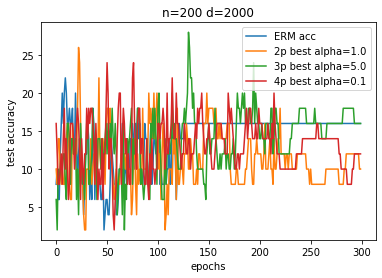

In [13]:
############################## start training ################################
for dim in [2000]:
  class MLP(torch.nn.Module):
      def __init__(self):
          super(MLP,self).__init__()
          self.fc1 = torch.nn.Linear(dim,800)
          self.fc2 = torch.nn.Linear(800,10)
        
      def forward(self,din):
          dout = torch.nn.functional.relu(self.fc1(din))
          output = self.fc2(dout)
          return output  
  for n in [200]:  
    epochsnew = 300 
    result_dict = defaultdict(list)
    f = open('dim={} n={}.txt'.format(dim, n), 'a')
    for run in range(10):     #run 10 times and take avg.
      x,y = sklearn.datasets.make_classification(n_samples=n, n_features=dim, n_informative=dim, n_redundant=0,
					n_repeated=0, n_classes=10, n_clusters_per_class=2, weights=None,
 					flip_y=0, class_sep=1, hypercube=True,shift=0.0, scale=1.0, 
					shuffle=True, random_state=None)

      train_x, train_y, test_x, test_y = balanceclass(0.75, 10, x, y)
      train = data_utils.TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
      train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)
      test = data_utils.TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())
      test_loader = data_utils.DataLoader(test, batch_size=128, shuffle=False)
      
      trainingmixup()
      trainingERM()
      #start saving every run's result:
      bestalphas = defaultdict(list)    #only need last run's plot
      for name,res in zip(['ERM', '2p', '3p', '4p'], [resultsori, results2, results3, results4]):
        res = np.array([res])[0]
        a = res[:,3].astype(float)
        globalbest_acc = np.max(a)    #pick the maximum among all alpha values
        idx = np.where(a == np.max(a))[0]
        best_alpha = res[:,1].astype(float)[idx]
        bestalphas[name].append(best_alpha)
        best_epoch = res[:,5].astype(int)[idx]
        print(f'for mixup {name}: global best acc = ', globalbest_acc, 'best alpha = ', best_alpha, 'global best epoch = ', best_epoch)
        result_dict[name].append(globalbest_acc)
        f.write('<{0}  {1}  {2}  {3}  {4} > \n'.format(run, name, globalbest_acc, best_alpha, best_epoch))
    #computing mean over 10 runs
    for i in ['2p','3p','4p','ERM']:
      mean = round(np.mean(result_dict[i]),4)
      std = round(np.std(result_dict[i]),4)
      f.write('start computing mean and std: \n')
      f.write('<{0}  {1}  {2}> \n'.format(i, mean, std))
    f.close()

    plt.figure()
    plt.title('n={} d={}'.format(n,dim))
    plt.plot(np.arange(len(accori)), accori, label = 'ERM acc')
    ba2p = bestalphas['2p'][0][0]
    ba3p = bestalphas['3p'][0][0]
    ba4p = bestalphas['4p'][0][0]
    print('ba4p', ba4p)
    loc2p = np.where([0.1, 1, 8, 12, 32] == ba2p)[0][0]
    loc3p = np.where([0.1, 1, 5, 12, 50] == ba3p)[0][0]  
    loc4p = np.where([0.1, 1, 5, 12, 50] == ba4p)[0][0] 
    print('loc4p', loc4p)
# plot the test acc over epochs obtained on the last run best alpha
    plt.plot(np.arange(300), acc2p[loc2p*300 : (loc2p+1)*300], label = '2p best alpha={}'.format(ba2p))
    plt.plot(np.arange(300), acc3p[loc3p*300 : (loc3p+1)*300], label = '3p best alpha={}'.format(ba3p))
    plt.plot(np.arange(300), acc4p[loc4p*300 : (loc4p+1)*300], label = '4p best alpha={}'.format(ba4p))
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('test accuracy')
    plt.savefig('n={} d={}.png'.format(n, dim))